# Task 3: Contrastive Models Analyzing CLIP ('ViT-B/32') and Multimodal Biases:

## Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

### Importing CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xiqkvcm2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xiqkvcm2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=212f1c3d9ee355037341240b7abed01667cd0faa90f7c254099b8527eab7dfa9
  Stored in directory: /tmp/pip-ephem-wheel-cache-14weh93p/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


Device:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


CLIP:

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:19<00:00, 18.2MiB/s]


## 1. Zero-shot classification on CIFAR

Downloading CIFAR10

In [ ]:
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


In [ ]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
prompts = [f"a photo of a {cifar_class}" for cifar_class in cifar10_classes]

For Text features:

In [ ]:
def clip_text_features(prompts):
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

Zero-shot classification:

In [ ]:
correct = 0
total = 0
text_features = clip_text_features(prompts)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = image_features @ text_features.T
        predicted_labels = logits.argmax(dim=-1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"Zero-shot classification accuracy on CIFAR-10 is: {accuracy:.4f}")

Zero-shot classification accuracy on CIFAR-10 is: 0.8874


### Comparison with fine-tuned ResNet

Getting From Repo:

In [ ]:
!wget https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth -O resnet_cifar10.pth

--2025-09-21 12:40:55--  https://github.com/farazahmad2004/ATML_Assignment_1/raw/main/Saved_Models/resnet_cifar10.pth
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth [following]
--2025-09-21 12:40:56--  https://raw.githubusercontent.com/farazahmad2004/ATML_Assignment_1/main/Saved_Models/resnet_cifar10.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94434345 (90M) [application/octet-stream]
Saving to: ‘resnet_cifar10.pth’

resnet_cifar10.pth  100%[===================>]  90.06M   331MB/s    in 0.3s    

2025-09-21 12:40:58 (

In [ ]:
import torchvision.models as models
fine_tuned_resnet = models.resnet50(pretrained=False, num_classes=10)
fine_tuned_resnet.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
fine_tuned_resnet = fine_tuned_resnet.to(device)
fine_tuned_resnet.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The ResNet model was fine-tuned using different transforms than the CLIP ones. So, evaluating it on CIFAR-10 with CLIP's transforms would result in an accuracy drop (which went down to $85\%$). So, to evaluate, I am using the original transforms (given below) on which the ResNet was fine-tuned.

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_test_resnet = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader_resnet = DataLoader(cifar10_test_resnet, batch_size=64, shuffle=False)

Evaluation

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_resnet:
        images, labels = images.to(device), labels.to(device)
        outputs = fine_tuned_resnet(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"Fine-tuned ResNet accuracy on CIFAR-10 is: {accuracy:.4f}")

Fine-tuned ResNet accuracy on CIFAR-10 is: 0.9524


### Domain-Shifted Classification:


#### PACS Dataset

In [ ]:
!pip install datasets pillow torchvision
from datasets import load_dataset

In [ ]:
# Downloading PACS sketch dataset
# as there is no 'test' split avaiable, I am making my own from 'train'
dataset = load_dataset("flwrlabs/pacs", split="train")
sketch_dataset = dataset.filter(lambda example: example["domain"] == "sketch")

In [ ]:
split = sketch_dataset.train_test_split(test_size=0.2, seed=42)
sketch_dataset_test = split["test"]
print(sketch_dataset_test)

Dataset({
    features: ['image', 'domain', 'label'],
    num_rows: 786
})


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
def pre_process_dataset(input):
    input["image"] = [transform(image.convert("RGB")) for image in input["image"]]
    return input
sketch_dataset_test = sketch_dataset_test.with_transform(pre_process_dataset)

In [ ]:
# data loader
sketch_dataloader = DataLoader(sketch_dataset_test, batch_size=64, shuffle=False)

#### CLIP

In [ ]:
pacs_classes = ["dog", "elephant", "giraffe", "horse", "person", "guitar", "house"]
pacs_prompts = [f"a sketch of a {pacs_class}" for pacs_class in pacs_classes]


Zero-shot classification

In [ ]:
text_features = clip_text_features(pacs_prompts)
correct = 0
total = 0
with torch.no_grad():
    for batch in sketch_dataloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = image_features @ text_features.T
        predicted_labels = logits.argmax(dim=-1)
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"Zero-shot CLIP classification accuracy on PACS-Sketch is: {accuracy:.4f}")

Zero-shot CLIP classification accuracy on PACS-Sketch is: 0.4224


#### Fine-tuned ResNet

Evaluation

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for batch in sketch_dataloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        outputs = fine_tuned_resnet(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"Fine-tuned ResNet accuracy on PACS-Sketch is: {accuracy:.4f}")

Fine-tuned ResNet accuracy on PACS-Sketch is: 0.1667


Note: Here, I am evaluating CIFAR-10 Fine-tuned resnet on PACS, which has different classes. So, kinda it is expected (that its acc. is 16.67).

## 2. Few-Shot or Prompt Engineering:

This was also done in PA0, where using `"a photo of a {class}"` vs. simply using `"class"` improved accuracy. Showing it again:

In [ ]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
simple_prompts = [f"{cifar_class}" for cifar_class in cifar10_classes]
descriptive_prompts = [f"a photo of a {cifar_class}" for cifar_class in cifar10_classes]

In [ ]:
prompt_sets = {"simple": simple_prompts,"descriptive": descriptive_prompts}
for prompt_name, prompts in prompt_sets.items():
    text_features = clip_text_features(prompts)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_features.T
            predicted_labels = logits.argmax(dim=-1)
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"CLIP's Zero-shot classification accuracy on CIFAR-10 using {prompt_name} prompts is: {accuracy:.4f}")

CLIP's Zero-shot classification accuracy on CIFAR-10 using simple prompts is: 0.8739
CLIP's Zero-shot classification accuracy on CIFAR-10 using descriptive prompts is: 0.8874


## 3. Image-Text Retrieval:

To show CLIP's multimodal alignment, I use 50 custom images with their captions stored in a `.json` file.

### Text-to-Image Retrieval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import json
import os

In [ ]:
# test images path
directory_path = "/content/drive/MyDrive/test_images"
# JSON file
json_path = "/content/captions.json"
with open(json_path, "r") as f:
    json_data = json.load(f)
# Colab sorts character by character, so the ordering was not as expected. So, I changed the key
def natural_sort_key(filename):
    parts = re.split(r'(\d+)', filename)
    return [int(part) if part.isdigit() else part.lower() for part in parts]
# Get all image filenames (sorted for consistency)
image_filenames = sorted(os.listdir(directory_path), key=natural_sort_key)


In [ ]:
image_embeddings = []
all_images = []
for filename in image_filenames:
    image_path = os.path.join(directory_path, filename)
    image = Image.open(image_path).convert("RGB")
    all_images.append(image)
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    image_embedding = model.encode_image(image_tensor)
    image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
    image_embeddings.append(image_embedding)
image_embeddings = torch.cat(image_embeddings, dim=0)

In [ ]:
queries = []
ground_truth = []
for index, item in enumerate(json_data):
    true_caption = item["labels"][item["index"]]
    queries.append(true_caption)
    ground_truth.append(index)

In [ ]:
# re-writing it here, so I don't have to go back above
def clip_text_features(prompts):
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

In [ ]:
text_embeddings = clip_text_features(queries)

In [ ]:
similarity = text_embeddings @ image_embeddings.T
# i am  evaluating on top-1 and top-5
top_k = 5
correct_top1 = 0
correct_top5 = 0
for i in range(len(queries)):
    values, indices = similarity[i].topk(top_k)
    if indices[0].item() == ground_truth[i]:
        correct_top1 += 1
    if ground_truth[i] in indices.tolist():
        correct_top5 += 1
    # only printing the first 5 to show
    if i < 5:
        print(f"\nQuery: {queries[i]}")
        print("Top matches:")
        for rank, idx in enumerate(indices):
            print(f"  Rank {rank+1}: Image {idx.item()} (sim={values[rank]:.3f})")



Query: a living room
Top matches:
  Rank 1: Image 44 (sim=0.280)
  Rank 2: Image 0 (sim=0.269)
  Rank 3: Image 2 (sim=0.266)
  Rank 4: Image 49 (sim=0.251)
  Rank 5: Image 21 (sim=0.235)

Query: a bear
Top matches:
  Rank 1: Image 1 (sim=0.289)
  Rank 2: Image 4 (sim=0.222)
  Rank 3: Image 46 (sim=0.211)
  Rank 4: Image 49 (sim=0.207)
  Rank 5: Image 31 (sim=0.206)

Query: a bedroom
Top matches:
  Rank 1: Image 2 (sim=0.302)
  Rank 2: Image 21 (sim=0.282)
  Rank 3: Image 44 (sim=0.268)
  Rank 4: Image 59 (sim=0.244)
  Rank 5: Image 49 (sim=0.243)

Query: a stop sign
Top matches:
  Rank 1: Image 3 (sim=0.321)
  Rank 2: Image 16 (sim=0.230)
  Rank 3: Image 12 (sim=0.218)
  Rank 4: Image 30 (sim=0.209)
  Rank 5: Image 49 (sim=0.204)

Query: teddy bears
Top matches:
  Rank 1: Image 4 (sim=0.284)
  Rank 2: Image 1 (sim=0.242)
  Rank 3: Image 27 (sim=0.215)
  Rank 4: Image 56 (sim=0.210)
  Rank 5: Image 41 (sim=0.208)


In [ ]:
n = len(queries)
print(f"Top-1 Accuracy: {correct_top1/n * 100:.2f}%")
print(f"Top-5 Accuracy: {correct_top5/n * 100:.2f}%")

Top-1 Accuracy: 71.67%
Top-5 Accuracy: 91.67%


Selected: [32, 36, 58]


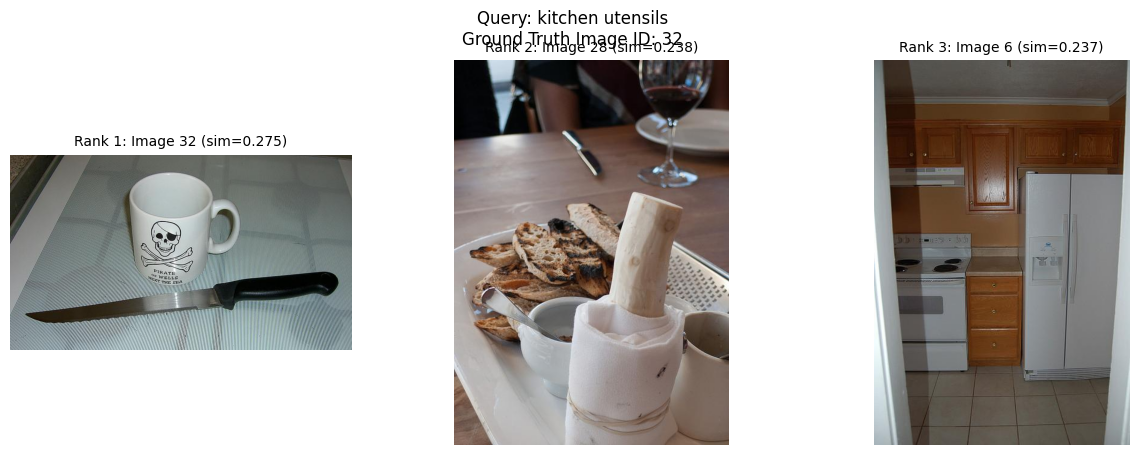

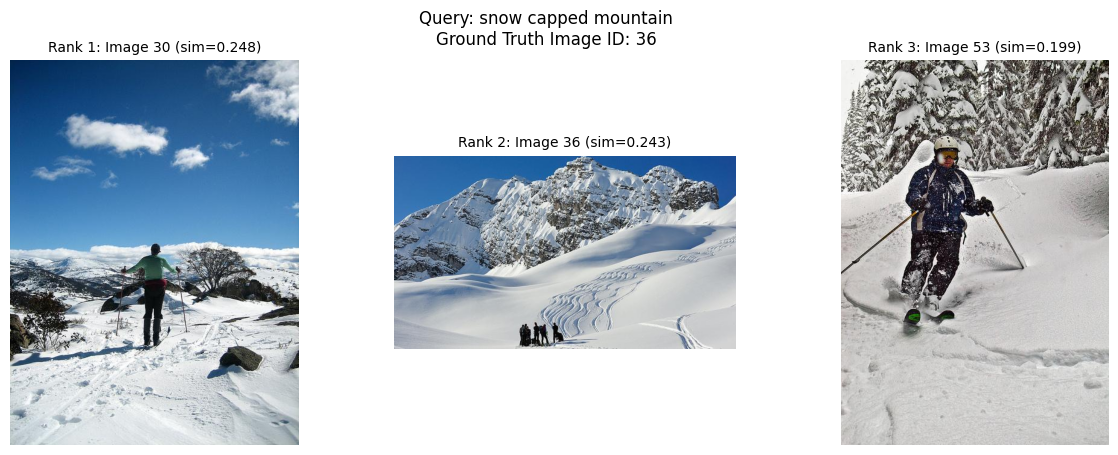

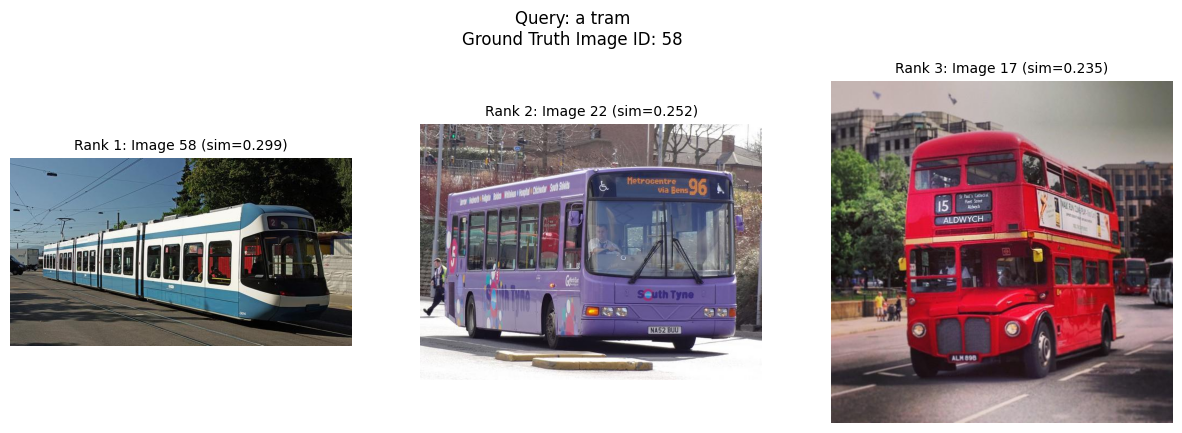

In [ ]:
# Also, showing them visually for 3 random i's
import random
import matplotlib.pyplot as plt
to_show_indices = random.sample(range(len(queries)), 3)
print("Selected:", to_show_indices)
for index in to_show_indices:
    query = queries[index]
    gt = ground_truth[index]
    values, indices = similarity[index].topk(3)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Query: {query}\nGround Truth Image ID: {gt}", fontsize=12)
    for rank, img_index in enumerate(indices):
        axs[rank].imshow(all_images[img_index])
        axs[rank].axis("off")
        axs[rank].set_title(f"Rank {rank+1}: Image {img_index.item()} (sim={values[rank]:.3f})", fontsize=10)
    plt.show()

### Image-to-text Retrieval


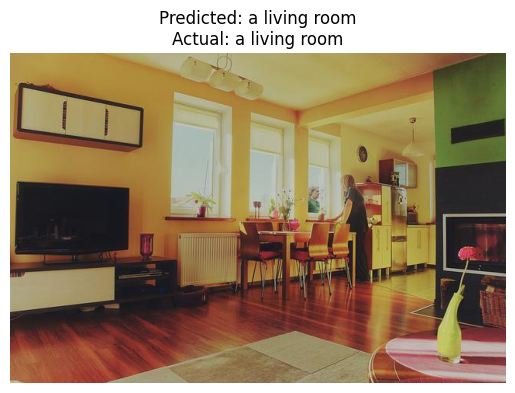

Image 1: Predicted: a living room | Actual: a living room


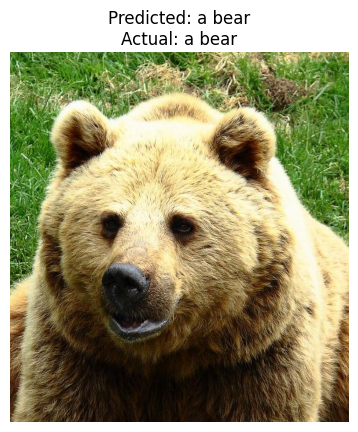

Image 2: Predicted: a bear | Actual: a bear


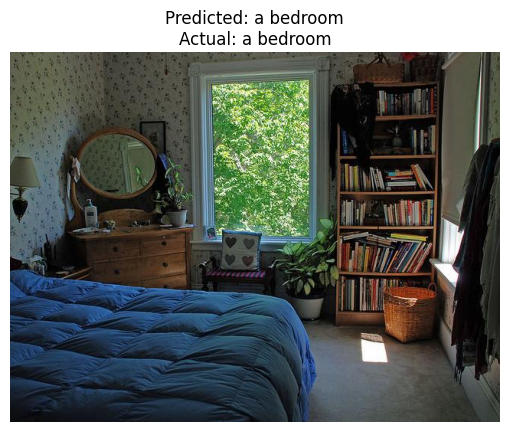

Image 3: Predicted: a bedroom | Actual: a bedroom
Image 4: Predicted: a stop sign | Actual: a stop sign
Image 5: Predicted: teddy bears | Actual: teddy bears
Image 6: Predicted: woman on ski | Actual: woman on ski
Image 7: Predicted: a kitchen | Actual: a kitchen
Image 8: Predicted: baseball players | Actual: baseball players
Image 9: Predicted: tennis player | Actual: tennis player
Image 10: Predicted: children playing sports | Actual: children playing sports
Image 11: Predicted: a riverside | Actual: a riverside
Image 12: Predicted: woman holding a phone | Actual: woman holding a phone
Image 13: Predicted: kids in a train | Actual: kids in a train
Image 14: Predicted: a hamburger | Actual: a hamburger
Image 15: Predicted: a man on a boat | Actual: a man on a boat
Image 16: Predicted: a desktop computer | Actual: a desktop computer
Image 17: Predicted: highway sign board | Actual: highway sign board
Image 18: Predicted: double decker bus | Actual: double decker bus
Image 19: Predicted

In [ ]:
correct_predictions = 0
total_images = len(image_filenames)
for idx, filename in enumerate(image_filenames):
    image_path = os.path.join(directory_path, filename)
    img = Image.open(image_path).convert("RGB")
    labels = json_data[idx]["labels"]
    actual_index = json_data[idx]["index"]
    image_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image_tensor)
        image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
    text_embeddings = clip_text_features(labels)
    similarity = (image_embedding @ text_embeddings.T).squeeze(0)
    predicted_index = similarity.argmax().item()
    if predicted_index == actual_index:
        correct_predictions += 1
    if idx < 3:
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Predicted: {labels[predicted_index]}\nActual: {labels[actual_index]}")
        plt.show()
    print(f"Image {idx+1}: Predicted: {labels[predicted_index]} | Actual: {labels[actual_index]}")



In [ ]:
accuracy = (correct_predictions / total_images) * 100
print(f"\nImage-to-Text Top-1 Accuracy: {accuracy:.2f}%")


Image-to-Text Top-1 Accuracy: 96.67%
